In [ ]:
!apt-get install -y poppler-utils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# Install necessary libraries and dependencies
!apt-get install -y poppler-utils
!pip install easyocr
!pip install Pillow
!pip install pdf2image



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import os
import cv2
import easyocr
from PIL import Image, ImageDraw
from pdf2image import convert_from_path
import json
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
def upload_file():
    print("Please upload your file (Image or PDF):")
    uploaded = files.upload()
    for file_name in uploaded.keys():
        return file_name

In [ ]:
def preprocess_image(image_path):
    # Original image
    img = cv2.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10, 10))
    plt.title("Grayscale Image")
    plt.imshow(gray_img, cmap='gray')
    plt.axis('off')
    plt.show()

    # Binarize the image
    _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    plt.figure(figsize=(10, 10))
    plt.title("Binary Image")
    plt.imshow(binary_img, cmap='gray')
    plt.axis('off')
    plt.show()

    # Denoise with median blur
    denoised_img = cv2.medianBlur(binary_img, 3)
    plt.figure(figsize=(10, 10))
    plt.title("Denoised Image")
    plt.imshow(denoised_img, cmap='gray')
    plt.axis('off')
    plt.show()

    return denoised_img



In [ ]:
def draw_boxes(img_path, bounds, color='green', width=2):
    image = Image.open(img_path)
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image


In [ ]:
def extract_text_from_image(image_path, preprocess=True):
    if preprocess:
        img = preprocess_image(image_path)
        img_path = "preprocessed_image.jpg"
        cv2.imwrite(img_path, img)  # Save the preprocessed image
        image_path = img_path

    reader = easyocr.Reader(['en'], gpu=False)  # Initialize EasyOCR
    result = reader.readtext(image_path, detail=1)
    extracted_text = "\n".join([item[1] for item in result])

    # Draw bounding boxes on the image
    processed_image = draw_boxes(image_path, result)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(processed_image)
    plt.axis('off')
    plt.show()

    return extracted_text

In [ ]:
def extract_text_from_pdf(pdf_path, output_dir="output"):
    pages = convert_from_path(pdf_path, 300)  # Convert PDF to images
    results = {}

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, page in enumerate(pages):
        image_path = os.path.join(output_dir, f"page_{i + 1}.jpg")
        page.save(image_path, "JPEG")

        text = extract_text_from_image(image_path)
        results[f"Page {i + 1}"] = text

    return results

In [ ]:
def save_results(results, output_file_json="results.json", output_file_txt="results.txt"):
    with open(output_file_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4)

    with open(output_file_txt, 'w', encoding='utf-8') as f:
        for page, text in results.items():
            f.write(f"{page}:\n")
            f.write(text)
            f.write("\n" + "="*50 + "\n")

Please upload your file (Image or PDF):


Saving proverb.jpg to proverb.jpg
Processing image...


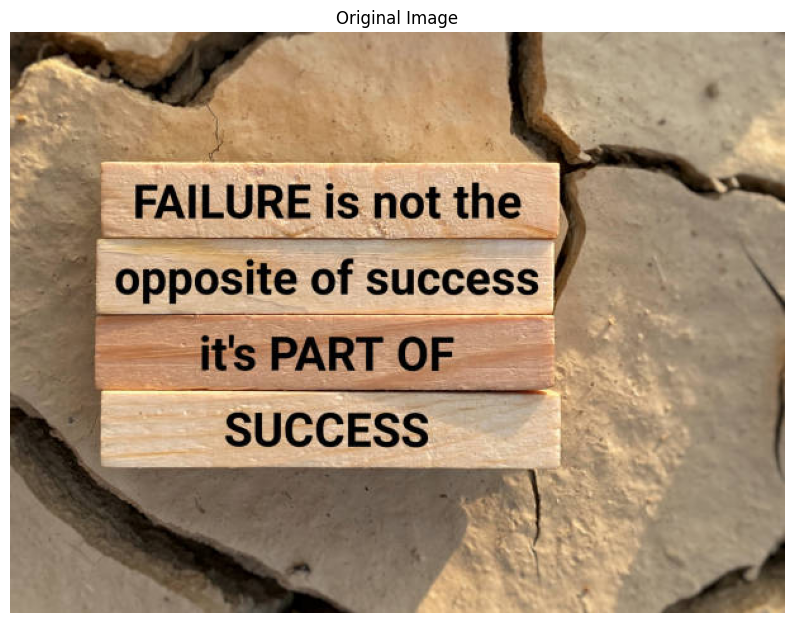

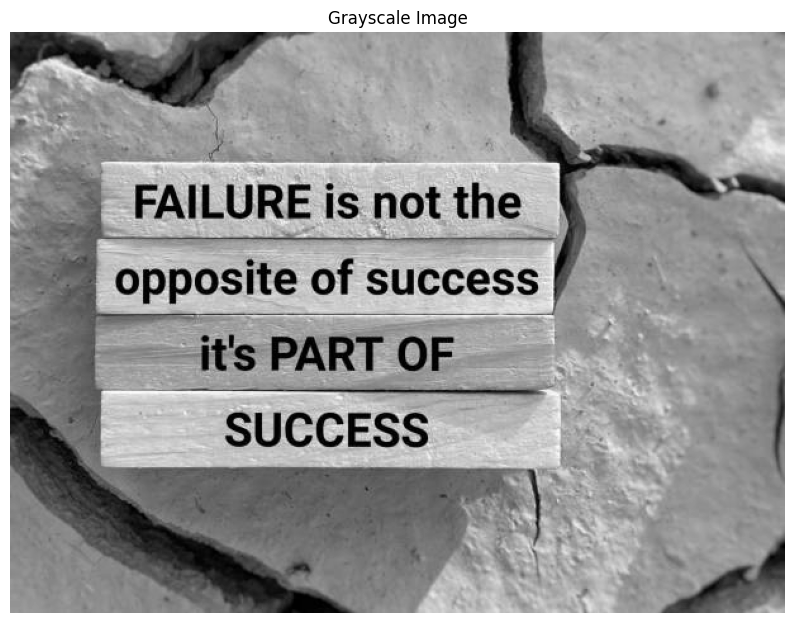

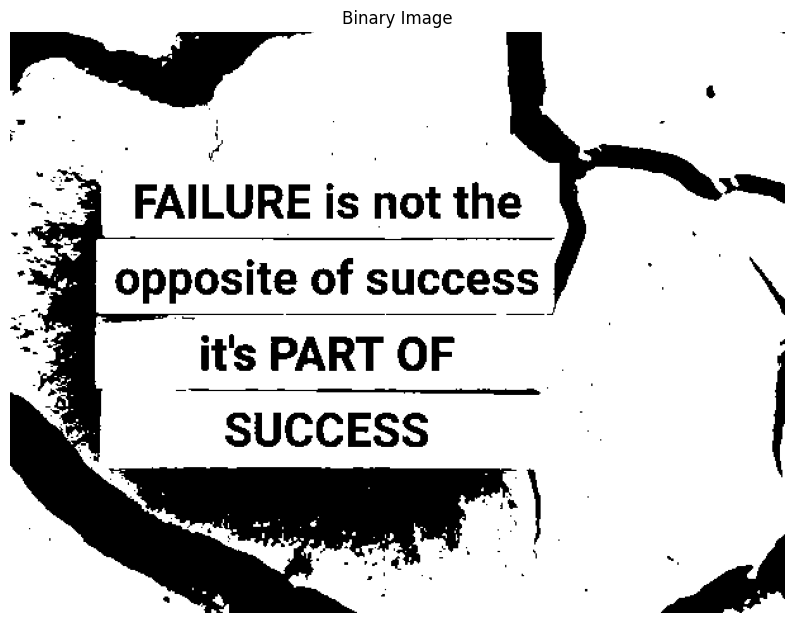

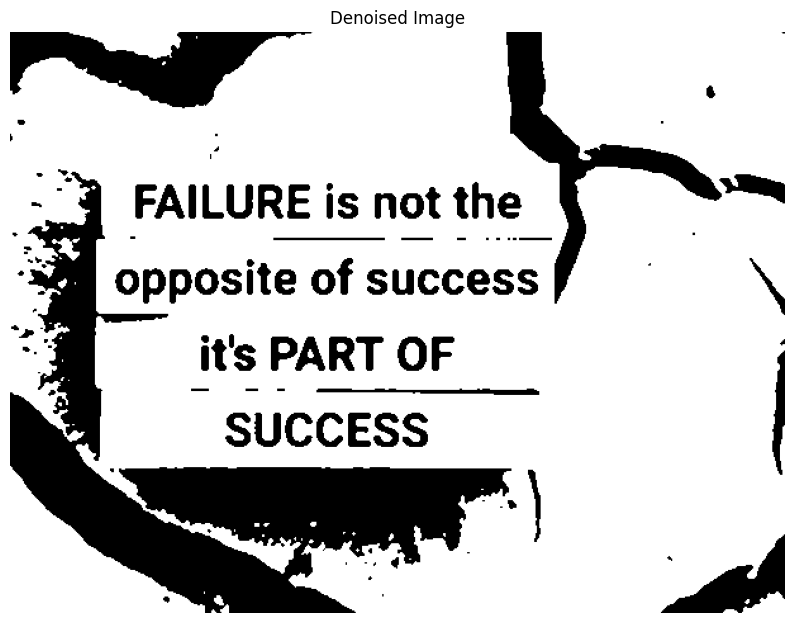

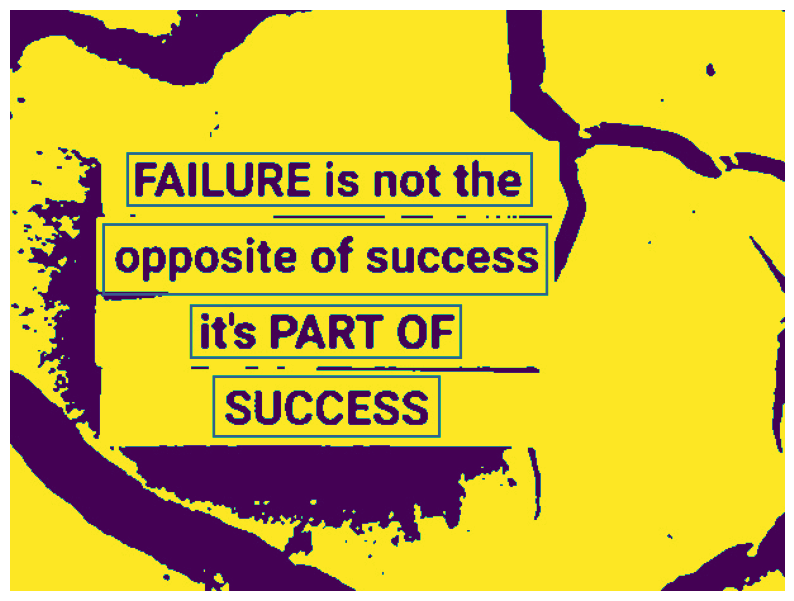


Extracted Text:
FAILURE is not the
opposite of success
its PART OF
SUCCESS


In [ ]:
def main():
    filename = upload_file()

    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        print("Processing image...")
        text = extract_text_from_image(filename, preprocess=True)
        print("\nExtracted Text:")
        print(text)

    elif filename.lower().endswith('.pdf'):
        print("Processing PDF...")
        results = extract_text_from_pdf(filename)
        save_results(results)
        print("Text extraction completed. Results saved to results.json and results.txt.")
        files.download("results.json")
        files.download("results.txt")

    else:
        print("Unsupported file format. Please upload a PNG, JPG, or PDF file.")

main()
